# Montar las carpetas de google drive.
# Create environment in Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


# Funciones para ejecutar el código

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [6]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [7]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [8]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [9]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}
dataframes_path = 'melanoma_without_duplicates_separated/'

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [11]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [12]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path=dataframes_path + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [13]:
val_df = pd.read_csv(dataframes_path + "val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [14]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, dataframes_path + "Pesos ResnetDA/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [15]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [16]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.conv1.weight
	 cnn.bn1.weight
	 cnn.bn1.bias
	 cnn.layer1.0.conv1.weight
	 cnn.layer1.0.bn1.weight
	 cnn.layer1.0.bn1.bias
	 cnn.layer1.0.conv2.weight
	 cnn.layer1.0.bn2.weight
	 cnn.layer1.0.bn2.bias
	 cnn.layer1.1.conv1.weight
	 cnn.layer1.1.bn1.weight
	 cnn.layer1.1.bn1.bias
	 cnn.layer1.1.conv2.weight
	 cnn.layer1.1.bn2.weight
	 cnn.layer1.1.bn2.bias
	 cnn.layer2.0.conv1.weight
	 cnn.layer2.0.bn1.weight
	 cnn.layer2.0.bn1.bias
	 cnn.layer2.0.conv2.weight
	 cnn.layer2.0.bn2.weight
	 cnn.layer2.0.bn2.bias
	 cnn.layer2.0.downsample.0.weight
	 cnn.layer2.0.downsample.1.weight
	 cnn.layer2.0.downsample.1.bias
	 cnn.layer2.1.conv1.weight
	 cnn.layer2.1.bn1.weight
	 cnn.layer2.1.bn1.bias
	 cnn.layer2.1.conv2.weight
	 cnn.layer2.1.bn2.weight
	 cnn.layer2.1.bn2.bias
	 cnn.layer3.0.conv1.weight
	 cnn.layer3.0.bn1.weight
	 cnn.layer3.0.bn1.bias
	 cnn.layer3.0.conv2.weight
	 cnn.layer3.0.bn2.weight
	 cnn.layer3.0.bn2.bias
	 cnn.layer3.0.downsample.0.weight
	 cnn.layer3.0

100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch:  0 Train Loss: 0.72575222 AUC: 0.54791667 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Epoch: 0 Val Loss: 0.72609097 AUC: 0.34345351 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:14<00:00,  1.86it/s]


Epoch:  1 Train Loss: 0.72181152 AUC: 0.54778325 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 1 Val Loss: 0.72096491 AUC: 0.42125237 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch:  2 Train Loss: 0.71592872 AUC: 0.64711632 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 2 Val Loss: 0.71371899 AUC: 0.56925996 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch:  3 Train Loss: 0.70534884 AUC: 0.69543651 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 3 Val Loss: 0.69896942 AUC: 0.71726755 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch:  4 Train Loss: 0.68846161 AUC: 0.81960784 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 4 Val Loss: 0.68430947 AUC: 0.77988615 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch:  5 Train Loss: 0.67497760 AUC: 0.83529412 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 5 Val Loss: 0.67254395 AUC: 0.74003795 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:15<00:00,  1.72it/s]


Epoch:  6 Train Loss: 0.66140201 AUC: 0.92375367 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 6 Val Loss: 0.66608380 AUC: 0.72296015 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch:  7 Train Loss: 0.65400532 AUC: 0.85490196 
[[9.99859076e-01 1.40924464e-04]
 [9.98365042e-01 1.63495838e-03]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 7 Val Loss: 0.66426862 AUC: 0.73055028 
[[0.99211712 0.00788288]
 [0.9875     0.0125    ]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch:  8 Train Loss: 0.64385685 AUC: 0.92382812 
[[0.99210823 0.00789177]
 [0.96062888 0.03937112]]


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch: 8 Val Loss: 0.65749528 AUC: 0.76470588 
[[0.96596597 0.03403403]
 [0.92804233 0.07195767]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch:  9 Train Loss: 0.62644319 AUC: 0.90575397 
[[0.9794814  0.0205186 ]
 [0.89690844 0.10309156]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 9 Val Loss: 0.65512867 AUC: 0.74003795 
[[0.94144144 0.05855856]
 [0.87142857 0.12857143]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 10 Train Loss: 0.61917653 AUC: 0.89655172 
[[0.96607564 0.03392436]
 [0.84228732 0.15771268]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 10 Val Loss: 0.65480507 AUC: 0.77798861 
[[0.92465192 0.07534808]
 [0.82943723 0.17056277]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 11 Train Loss: 0.61628142 AUC: 0.82287449 
[[0.95424652 0.04575348]
 [0.79409433 0.20590567]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 11 Val Loss: 0.64536220 AUC: 0.81404175 
[[0.91103604 0.08896396]
 [0.78531746 0.21468254]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 12 Train Loss: 0.61149195 AUC: 0.91202346 
[[0.94597173 0.05402827]
 [0.75596817 0.24403183]]


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch: 12 Val Loss: 0.65947642 AUC: 0.71347249 
[[0.9002079  0.0997921 ]
 [0.75897436 0.24102564]]


100%|██████████| 27/27 [00:14<00:00,  1.90it/s]


Epoch: 13 Train Loss: 0.61224197 AUC: 0.83743842 
[[0.93976486 0.06023514]
 [0.72447766 0.27552234]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 13 Val Loss: 0.65127115 AUC: 0.80834915 
[[0.88867439 0.11132561]
 [0.72857143 0.27142857]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 14 Train Loss: 0.61444624 AUC: 0.82058824 
[[0.93423525 0.06576475]
 [0.69789933 0.30210067]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 14 Val Loss: 0.63689229 AUC: 0.79886148 
[[0.88108108 0.11891892]
 [0.69968254 0.30031746]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 15 Train Loss: 0.60765419 AUC: 0.94994995 
[[0.92932638 0.07067362]
 [0.67174495 0.32825505]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 15 Val Loss: 0.65757647 AUC: 0.73244782 
[[0.87359234 0.12640766]
 [0.68125    0.31875   ]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 16 Train Loss: 0.60353065 AUC: 0.80882353 
[[0.92652033 0.07347967]
 [0.64957683 0.35042317]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 16 Val Loss: 0.64628180 AUC: 0.82542694 
[[0.86565978 0.13434022]
 [0.65882353 0.34117647]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 17 Train Loss: 0.60394881 AUC: 0.95294118 
[[0.92239759 0.07760241]
 [0.62848461 0.37151539]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 17 Val Loss: 0.65679221 AUC: 0.77229602 
[[0.85885886 0.14114114]
 [0.64312169 0.35687831]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 18 Train Loss: 0.60500711 AUC: 0.91886608 
[[0.91912419 0.08087581]
 [0.61123975 0.38876025]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 18 Val Loss: 0.64356459 AUC: 0.83681214 
[[0.85514462 0.14485538]
 [0.62807018 0.37192982]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 19 Train Loss: 0.59972493 AUC: 0.78441296 
[[0.91719278 0.08280722]
 [0.59482759 0.40517241]]


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch: 19 Val Loss: 0.65801461 AUC: 0.80265655 
[[0.8518018  0.1481982 ]
 [0.61928571 0.38071429]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 20 Train Loss: 0.59909673 AUC: 0.89064039 
[[0.91619692 0.08380308]
 [0.58184701 0.41815299]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 20 Val Loss: 0.64811013 AUC: 0.78557875 
[[0.84706135 0.15293865]
 [0.60521542 0.39478458]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 21 Train Loss: 0.59893403 AUC: 0.90344828 
[[0.91375423 0.08624577]
 [0.56707383 0.43292617]]


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch: 21 Val Loss: 0.64807765 AUC: 0.75711575 
[[0.84131859 0.15868141]
 [0.59004329 0.40995671]]


100%|██████████| 27/27 [00:15<00:00,  1.79it/s]


Epoch: 22 Train Loss: 0.59853598 AUC: 0.94146825 
[[0.91201412 0.08798588]
 [0.55410226 0.44589774]]


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 22 Val Loss: 0.65239848 AUC: 0.75142315 
[[0.83764199 0.16235801]
 [0.57971014 0.42028986]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 23 Train Loss: 0.59424578 AUC: 0.92954545 
[[0.91173431 0.08826569]
 [0.54340071 0.45659929]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 23 Val Loss: 0.64706062 AUC: 0.77798861 
[[0.83502252 0.16497748]
 [0.57162698 0.42837302]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 24 Train Loss: 0.59453882 AUC: 0.94019608 
[[0.91120631 0.08879369]
 [0.53331748 0.46668252]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 24 Val Loss: 0.64145095 AUC: 0.81783681 
[[0.83243243 0.16756757]
 [0.56114286 0.43885714]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 25 Train Loss: 0.59160302 AUC: 0.90000000 
[[0.91032868 0.08967132]
 [0.52259215 0.47740785]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 25 Val Loss: 0.64163091 AUC: 0.79886148 
[[0.82986833 0.17013167]
 [0.5518315  0.4481685 ]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 26 Train Loss: 0.59567205 AUC: 0.94146825 
[[0.90951605 0.09048395]
 [0.51393843 0.48606157]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 26 Val Loss: 0.64092372 AUC: 0.81783681 
[[0.82682683 0.17317317]
 [0.54197531 0.45802469]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 27 Train Loss: 0.59319842 AUC: 0.93750000 
[[0.90860042 0.09139958]
 [0.50526584 0.49473416]]


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch: 27 Val Loss: 0.65363468 AUC: 0.81783681 
[[0.82335907 0.17664093]
 [0.53435374 0.46564626]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 28 Train Loss: 0.58826612 AUC: 0.90738916 
[[0.90836994 0.09163006]
 [0.49686334 0.50313666]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 28 Val Loss: 0.64042307 AUC: 0.80455408 
[[0.82199441 0.17800559]
 [0.527422   0.472578  ]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 29 Train Loss: 0.58279142 AUC: 0.96676442 
[[0.90807967 0.09192033]
 [0.48818866 0.51181134]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 29 Val Loss: 0.64604660 AUC: 0.83111954 
[[0.81951952 0.18048048]
 [0.52047619 0.47952381]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 30 Train Loss: 0.58995740 AUC: 0.92413793 
[[0.90795359 0.09204641]
 [0.48141613 0.51858387]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 30 Val Loss: 0.64512203 AUC: 0.88804554 
[[0.81778553 0.18221447]
 [0.51428571 0.48571429]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 31 Train Loss: 0.59152887 AUC: 0.93623482 
[[0.90741263 0.09258737]
 [0.47465815 0.52534185]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 31 Val Loss: 0.64822599 AUC: 0.75901328 
[[0.81475225 0.18524775]
 [0.50699405 0.49300595]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 32 Train Loss: 0.58879115 AUC: 0.93293293 
[[0.90710943 0.09289057]
 [0.46820164 0.53179836]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 32 Val Loss: 0.63940522 AUC: 0.88235294 
[[0.81217581 0.18782419]
 [0.4991342  0.5008658 ]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 33 Train Loss: 0.58691952 AUC: 0.88660802 
[[0.90718881 0.09281119]
 [0.4624047  0.5375953 ]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 33 Val Loss: 0.65060090 AUC: 0.83111954 
[[0.80975093 0.19024907]
 [0.49439776 0.50560224]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 34 Train Loss: 0.58761035 AUC: 0.93596059 
[[0.90742471 0.09257529]
 [0.45710888 0.54289112]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 34 Val Loss: 0.63309463 AUC: 0.84250474 
[[0.80875161 0.19124839]
 [0.48829932 0.51170068]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 35 Train Loss: 0.58825813 AUC: 0.92647059 
[[0.90717775 0.09282225]
 [0.45181001 0.54818999]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 35 Val Loss: 0.63776877 AUC: 0.86337761 
[[0.80755756 0.19244244]
 [0.48267196 0.51732804]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 36 Train Loss: 0.58669506 AUC: 0.89261084 
[[0.90715744 0.09284256]
 [0.44666902 0.55333098]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 36 Val Loss: 0.64067623 AUC: 0.85009488 
[[0.80630631 0.19369369]
 [0.47786358 0.52213642]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 37 Train Loss: 0.58312832 AUC: 0.91136364 
[[0.90749421 0.09250579]
 [0.44186119 0.55813881]]


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch: 37 Val Loss: 0.64062347 AUC: 0.81214421 
[[0.80547653 0.19452347]
 [0.47418546 0.52581454]]


100%|██████████| 27/27 [00:14<00:00,  1.80it/s]


Epoch: 38 Train Loss: 0.58271426 AUC: 0.98511905 
[[0.90787153 0.09212847]
 [0.43739138 0.56260862]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 38 Val Loss: 0.64546539 AUC: 0.81593928 
[[0.8045738  0.1954262 ]
 [0.47045177 0.52954823]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 39 Train Loss: 0.57985753 AUC: 0.93431373 
[[0.90808906 0.09191094]
 [0.4324019  0.5675981 ]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 39 Val Loss: 0.65057188 AUC: 0.83870968 
[[0.80236486 0.19763514]
 [0.46607143 0.53392857]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 40 Train Loss: 0.58501694 AUC: 0.90909091 
[[0.90837847 0.09162153]
 [0.42875787 0.57124213]]


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch: 40 Val Loss: 0.64383027 AUC: 0.82163188 
[[0.80158207 0.19841793]
 [0.46271777 0.53728223]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 41 Train Loss: 0.58553248 AUC: 0.90136719 
[[0.90854673 0.09145327]
 [0.42497594 0.57502406]]


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch: 41 Val Loss: 0.65123605 AUC: 0.76091082 
[[0.79933505 0.20066495]
 [0.45770975 0.54229025]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 42 Train Loss: 0.58537997 AUC: 0.94330401 
[[0.90881204 0.09118796]
 [0.42184    0.57816   ]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 42 Val Loss: 0.64326463 AUC: 0.78747628 
[[0.79761157 0.20238843]
 [0.4530454  0.5469546 ]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 43 Train Loss: 0.57868571 AUC: 0.93201970 
[[0.90906529 0.09093471]
 [0.41776565 0.58223435]]


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch: 43 Val Loss: 0.64379863 AUC: 0.79886148 
[[0.79545455 0.20454545]
 [0.44816017 0.55183983]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 44 Train Loss: 0.57777972 AUC: 0.87887888 
[[0.90948265 0.09051735]
 [0.41418946 0.58581054]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 44 Val Loss: 0.65487653 AUC: 0.75142315 
[[0.79359359 0.20640641]
 [0.4447619  0.5552381 ]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 45 Train Loss: 0.57892259 AUC: 0.95172414 
[[0.91002892 0.08997108]
 [0.41107894 0.58892106]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 45 Val Loss: 0.65283248 AUC: 0.75142315 
[[0.79279279 0.20720721]
 [0.44296066 0.55703934]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 46 Train Loss: 0.57972863 AUC: 0.92843137 
[[0.91024011 0.08975989]
 [0.4077466  0.5922534 ]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 46 Val Loss: 0.64879460 AUC: 0.87286528 
[[0.79164271 0.20835729]
 [0.44002026 0.55997974]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 47 Train Loss: 0.57805223 AUC: 0.87179487 
[[0.91058343 0.08941657]
 [0.4044788  0.5955212 ]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 47 Val Loss: 0.64488595 AUC: 0.82542694 
[[0.79016517 0.20983483]
 [0.43660714 0.56339286]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 48 Train Loss: 0.57910347 AUC: 0.88888889 
[[0.91098175 0.08901825]
 [0.4016113  0.5983887 ]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 48 Val Loss: 0.65588788 AUC: 0.75142315 
[[0.78883986 0.21116014]
 [0.43411079 0.56588921]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 49 Train Loss: 0.57787088 AUC: 0.93255132 
[[0.9118602 0.0881398]
 [0.3996195 0.6003805]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 49 Val Loss: 0.65889554 AUC: 0.63757116 
[[0.78765766 0.21234234]
 [0.43228571 0.56771429]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 50 Train Loss: 0.57826899 AUC: 0.97321429 
[[0.91254946 0.08745054]
 [0.3973794  0.6026206 ]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 50 Val Loss: 0.64523774 AUC: 0.76470588 
[[0.78625685 0.21374315]
 [0.4286648  0.5713352 ]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 51 Train Loss: 0.57780259 AUC: 0.96676442 
[[0.9129954 0.0870046]
 [0.394791  0.605209 ]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 51 Val Loss: 0.65002860 AUC: 0.77988615 
[[0.78499653 0.21500347]
 [0.42591575 0.57408425]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 52 Train Loss: 0.57443000 AUC: 0.98226601 
[[0.91359469 0.08640531]
 [0.39234514 0.60765486]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 52 Val Loss: 0.65640485 AUC: 0.72770398 
[[0.78344382 0.21655618]
 [0.42336029 0.57663971]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 53 Train Loss: 0.57620462 AUC: 0.87087087 
[[0.91373335 0.08626665]
 [0.38943938 0.61056062]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 53 Val Loss: 0.64805315 AUC: 0.81024668 
[[0.78211545 0.21788455]
 [0.42028219 0.57971781]]


100%|██████████| 27/27 [00:15<00:00,  1.77it/s]


Epoch: 54 Train Loss: 0.57952302 AUC: 0.94705882 
[[0.91431793 0.08568207]
 [0.38761215 0.61238785]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 54 Val Loss: 0.63983325 AUC: 0.80929791 
[[0.78149058 0.21850942]
 [0.41731602 0.58268398]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 55 Train Loss: 0.57820706 AUC: 0.93627451 
[[0.91441859 0.08558141]
 [0.38493715 0.61506285]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 55 Val Loss: 0.64199086 AUC: 0.81973435 
[[0.78096847 0.21903153]
 [0.41479592 0.58520408]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 56 Train Loss: 0.57405287 AUC: 0.90541872 
[[0.91501019 0.08498981]
 [0.38279408 0.61720592]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 56 Val Loss: 0.67219972 AUC: 0.70777989 
[[0.78006954 0.21993046]
 [0.41512114 0.58487886]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 57 Train Loss: 0.57985157 AUC: 0.92307692 
[[0.91528982 0.08471018]
 [0.38109394 0.61890606]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 57 Val Loss: 0.64229369 AUC: 0.82542694 
[[0.77951227 0.22048773]
 [0.41297209 0.58702791]]


100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Epoch: 58 Train Loss: 0.57713302 AUC: 0.91862745 
[[0.91521602 0.08478398]
 [0.37826236 0.62173764]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 58 Val Loss: 0.64374940 AUC: 0.81973435 
[[0.77927928 0.22072072]
 [0.41146086 0.58853914]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 59 Train Loss: 0.57870656 AUC: 0.93993994 
[[0.91546411 0.08453589]
 [0.37635751 0.62364249]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 59 Val Loss: 0.64774075 AUC: 0.78368121 
[[0.7792042  0.2207958 ]
 [0.41047619 0.58952381]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 60 Train Loss: 0.57008234 AUC: 0.89980159 
[[0.9161846 0.0838154]
 [0.3745541 0.6254459]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 60 Val Loss: 0.66590263 AUC: 0.70018975 
[[0.7776547 0.2223453]
 [0.4088993 0.5911007]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 61 Train Loss: 0.57161730 AUC: 0.93255132 
[[0.91675456 0.08324544]
 [0.37255955 0.62744045]]


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch: 61 Val Loss: 0.64517929 AUC: 0.81214421 
[[0.77739029 0.22260971]
 [0.40721966 0.59278034]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 62 Train Loss: 0.58011920 AUC: 0.96153846 
[[0.91716326 0.08283674]
 [0.37113791 0.62886209]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 62 Val Loss: 0.67826919 AUC: 0.68880455 
[[0.77606178 0.22393822]
 [0.40702948 0.59297052]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 63 Train Loss: 0.57686641 AUC: 0.94117647 
[[0.91766488 0.08233512]
 [0.36983502 0.63016498]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 63 Val Loss: 0.65496084 AUC: 0.76660342 
[[0.77526745 0.22473255]
 [0.40550595 0.59449405]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 64 Train Loss: 0.57571819 AUC: 0.94726562 
[[0.91799497 0.08200503]
 [0.36820635 0.63179365]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 64 Val Loss: 0.65013977 AUC: 0.74383302 
[[0.77387387 0.22612613]
 [0.40234432 0.59765568]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 65 Train Loss: 0.57497701 AUC: 0.95960591 
[[0.91828089 0.08171911]
 [0.3664829  0.6335171 ]]


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch: 65 Val Loss: 0.65344125 AUC: 0.80834915 
[[0.77245427 0.22754573]
 [0.39992785 0.60007215]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 66 Train Loss: 0.57235847 AUC: 0.91202346 
[[0.91862559 0.08137441]
 [0.36479316 0.63520684]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 66 Val Loss: 0.65875589 AUC: 0.72675522 
[[0.77080812 0.22919188]
 [0.39737029 0.60262971]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 67 Train Loss: 0.57146387 AUC: 0.90429688 
[[0.91914252 0.08085748]
 [0.36327551 0.63672449]]


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 67 Val Loss: 0.66243602 AUC: 0.61480076 
[[0.76967409 0.23032591]
 [0.39572829 0.60427171]]


100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch: 68 Train Loss: 0.57168767 AUC: 0.97647059 
[[0.91951375 0.08048625]
 [0.36173293 0.63826707]]


100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Epoch: 68 Val Loss: 0.66378675 AUC: 0.72106262 
[[0.76805066 0.23194934]
 [0.39351277 0.60648723]]


100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


Epoch: 69 Train Loss: 0.57527634 AUC: 0.93646139 
[[0.91968111 0.08031889]
 [0.3601325  0.6398675 ]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 69 Val Loss: 0.67599474 AUC: 0.63377609 
[[0.76743887 0.23256113]
 [0.39387755 0.60612245]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 70 Train Loss: 0.57430302 AUC: 0.98153846 
[[0.9199549  0.0800451 ]
 [0.35871113 0.64128887]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 70 Val Loss: 0.65467890 AUC: 0.72865275 
[[0.76589265 0.23410735]
 [0.39128102 0.60871898]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 71 Train Loss: 0.57264256 AUC: 0.89574899 
[[0.92022109 0.07977891]
 [0.35716409 0.64283591]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 71 Val Loss: 0.64450402 AUC: 0.76470588 
[[0.76501502 0.23498498]
 [0.38888889 0.61111111]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 72 Train Loss: 0.56775116 AUC: 0.91372549 
[[0.92057266 0.07942734]
 [0.35546398 0.64453602]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 72 Val Loss: 0.64818023 AUC: 0.83301708 
[[0.76397631 0.23602369]
 [0.38649706 0.61350294]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 73 Train Loss: 0.56791492 AUC: 0.96500530 
[[0.92099089 0.07900911]
 [0.35405084 0.64594916]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 73 Val Loss: 0.65337536 AUC: 0.79127135 
[[0.76357439 0.23642561]
 [0.38577864 0.61422136]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 74 Train Loss: 0.57045133 AUC: 0.88085938 
[[0.92142803 0.07857197]
 [0.35286564 0.64713436]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 74 Val Loss: 0.64595644 AUC: 0.83491461 
[[0.763003 0.236997]
 [0.384    0.616   ]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 75 Train Loss: 0.57065352 AUC: 0.89313725 
[[0.92180917 0.07819083]
 [0.35161775 0.64838225]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 75 Val Loss: 0.65590708 AUC: 0.76280835 
[[0.76232812 0.23767188]
 [0.38295739 0.61704261]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 76 Train Loss: 0.56817383 AUC: 0.94037146 
[[0.92212185 0.07787815]
 [0.34995445 0.65004555]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 76 Val Loss: 0.65787525 AUC: 0.74003795 
[[0.76120276 0.23879724]
 [0.38101422 0.61898578]]


100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch: 77 Train Loss: 0.56825640 AUC: 0.93359375 
[[0.92270112 0.07729888]
 [0.3489893  0.6510107 ]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 77 Val Loss: 0.65212721 AUC: 0.75901328 
[[0.76103026 0.23896974]
 [0.38052503 0.61947497]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 78 Train Loss: 0.56800556 AUC: 0.93841642 
[[0.92316584 0.07683416]
 [0.34780776 0.65219224]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 78 Val Loss: 0.64627014 AUC: 0.84250474 
[[0.76046299 0.23953701]
 [0.37926462 0.62073538]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 79 Train Loss: 0.56949398 AUC: 0.90729167 
[[0.92374577 0.07625423]
 [0.34705707 0.65294293]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 79 Val Loss: 0.64043156 AUC: 0.86337761 
[[0.76024775 0.23975225]
 [0.37809524 0.62190476]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 80 Train Loss: 0.56692953 AUC: 0.92473118 
[[0.92389383 0.07610617]
 [0.34535606 0.65464394]]


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch: 80 Val Loss: 0.66396295 AUC: 0.68975332 
[[0.75959293 0.24040707]
 [0.3776602  0.6223398 ]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 81 Train Loss: 0.57559963 AUC: 0.94921875 
[[0.924327   0.075673  ]
 [0.34482759 0.65517241]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 81 Val Loss: 0.67088751 AUC: 0.71537002 
[[0.75823995 0.24176005]
 [0.37636469 0.62363531]]


100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Epoch: 82 Train Loss: 0.56577670 AUC: 0.97753906 
[[0.92468182 0.07531818]
 [0.34342364 0.65657636]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 82 Val Loss: 0.63658614 AUC: 0.83206831 
[[0.75822208 0.24177792]
 [0.37498566 0.62501434]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 83 Train Loss: 0.56700369 AUC: 0.95436508 
[[0.92517582 0.07482418]
 [0.34243531 0.65756469]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 83 Val Loss: 0.66007859 AUC: 0.76280835 
[[0.75718576 0.24281424]
 [0.3734127  0.6265873 ]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 84 Train Loss: 0.56648364 AUC: 0.96650246 
[[0.92544598 0.07455402]
 [0.34112051 0.65887949]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 84 Val Loss: 0.63624639 AUC: 0.83301708 
[[0.75739269 0.24260731]
 [0.37238095 0.62761905]]


100%|██████████| 27/27 [00:15<00:00,  1.80it/s]


Epoch: 85 Train Loss: 0.56306281 AUC: 0.98051282 
[[0.9260376  0.0739624 ]
 [0.34005752 0.65994248]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 85 Val Loss: 0.64203304 AUC: 0.78083491 
[[0.75717578 0.24282422]
 [0.37109635 0.62890365]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 86 Train Loss: 0.56536357 AUC: 0.93450635 
[[0.92627869 0.07372131]
 [0.33871827 0.66128173]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 86 Val Loss: 0.64624476 AUC: 0.84819734 
[[0.75706741 0.24293259]
 [0.37044335 0.62955665]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 87 Train Loss: 0.56957859 AUC: 0.94894895 
[[0.92660398 0.07339602]
 [0.33776078 0.66223922]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 87 Val Loss: 0.65471530 AUC: 0.78747628 
[[0.75639844 0.24360156]
 [0.36920996 0.63079004]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 88 Train Loss: 0.56351983 AUC: 0.90049261 
[[0.92703596 0.07296404]
 [0.33663776 0.66336224]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 88 Val Loss: 0.65454973 AUC: 0.77609108 
[[0.75564328 0.24435672]
 [0.36795078 0.63204922]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 89 Train Loss: 0.56592674 AUC: 0.93059629 
[[0.92727045 0.07272955]
 [0.33535474 0.66464526]]


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 89 Val Loss: 0.65496377 AUC: 0.70777989 
[[0.75520521 0.24479479]
 [0.36703704 0.63296296]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 90 Train Loss: 0.56529622 AUC: 0.98431373 
[[0.92762367 0.07237633]
 [0.33420444 0.66579556]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 90 Val Loss: 0.64718154 AUC: 0.75332068 
[[0.75512326 0.24487674]
 [0.36640502 0.63359498]]


100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Epoch: 91 Train Loss: 0.56640704 AUC: 0.93722944 
[[0.92793245 0.07206755]
 [0.33318255 0.66681745]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 91 Val Loss: 0.65624913 AUC: 0.81593928 
[[0.75455347 0.24544653]
 [0.36547619 0.63452381]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 92 Train Loss: 0.56628015 AUC: 0.90790791 
[[0.92808912 0.07191088]
 [0.33196527 0.66803473]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 92 Val Loss: 0.65488837 AUC: 0.82542694 
[[0.75438342 0.24561658]
 [0.36497696 0.63502304]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 93 Train Loss: 0.55913346 AUC: 0.93004926 
[[0.92856629 0.07143371]
 [0.33083715 0.66916285]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 93 Val Loss: 0.65340168 AUC: 0.82163188 
[[0.75407322 0.24592678]
 [0.36428571 0.63571429]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 94 Train Loss: 0.56442521 AUC: 0.93847656 
[[0.92881979 0.07118021]
 [0.32967019 0.67032981]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 94 Val Loss: 0.66012727 AUC: 0.71537002 
[[0.75315315 0.24684685]
 [0.36310777 0.63689223]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 95 Train Loss: 0.56355376 AUC: 0.96453202 
[[0.92899756 0.07100244]
 [0.3283913  0.6716087 ]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 95 Val Loss: 0.65086858 AUC: 0.78178368 
[[0.75243994 0.24756006]
 [0.36145833 0.63854167]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 96 Train Loss: 0.56481676 AUC: 0.95670996 
[[0.92933437 0.07066563]
 [0.32751879 0.67248121]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 96 Val Loss: 0.65724416 AUC: 0.82542694 
[[0.75155568 0.24844432]
 [0.36013746 0.63986254]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 97 Train Loss: 0.56027752 AUC: 0.92216749 
[[0.92958378 0.07041622]
 [0.32621515 0.67378485]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 97 Val Loss: 0.64183625 AUC: 0.82922201 
[[0.75137893 0.24862107]
 [0.35913508 0.64086492]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 98 Train Loss: 0.56116422 AUC: 0.92292292 
[[0.92985093 0.07014907]
 [0.32508197 0.67491803]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 98 Val Loss: 0.65947320 AUC: 0.74573055 
[[0.75061425 0.24938575]
 [0.35810486 0.64189514]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 99 Train Loss: 0.56067820 AUC: 0.94901961 
[[0.93015784 0.06984216]
 [0.32400713 0.67599287]]


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: 99 Val Loss: 0.65873992 AUC: 0.69639469 
[[0.75       0.25      ]
 [0.35747619 0.64252381]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 100 Train Loss: 0.56016301 AUC: 0.94037146 
[[0.93059261 0.06940739]
 [0.32310663 0.67689337]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 100 Val Loss: 0.66092593 AUC: 0.73719165 
[[0.74899652 0.25100348]
 [0.35615276 0.64384724]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 101 Train Loss: 0.56305942 AUC: 0.94803922 
[[0.93093043 0.06906957]
 [0.32225875 0.67774125]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 101 Val Loss: 0.67599558 AUC: 0.59582543 
[[0.74818937 0.25181063]
 [0.35583567 0.64416433]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 102 Train Loss: 0.55954868 AUC: 0.96871945 
[[0.93131643 0.06868357]
 [0.32145042 0.67854958]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 102 Val Loss: 0.65800583 AUC: 0.76280835 
[[0.74713548 0.25286452]
 [0.35409154 0.64590846]]


100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Epoch: 103 Train Loss: 0.56037079 AUC: 0.98137255 
[[0.93160827 0.06839173]
 [0.32032608 0.67967392]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 103 Val Loss: 0.65338057 AUC: 0.73624288 
[[0.74644837 0.25355163]
 [0.35302198 0.64697802]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 104 Train Loss: 0.56105769 AUC: 0.90837438 
[[0.93177645 0.06822355]
 [0.31916653 0.68083347]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 104 Val Loss: 0.65818838 AUC: 0.66982922 
[[0.74581725 0.25418275]
 [0.3521542  0.6478458 ]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 105 Train Loss: 0.56456231 AUC: 0.93551587 
[[0.93204782 0.06795218]
 [0.31842147 0.68157853]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 105 Val Loss: 0.65528371 AUC: 0.81309298 
[[0.74507054 0.25492946]
 [0.3509434  0.6490566 ]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 106 Train Loss: 0.55993581 AUC: 0.90049261 
[[0.93232465 0.06767535]
 [0.31750142 0.68249858]]


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch: 106 Val Loss: 0.65196968 AUC: 0.66413662 
[[0.74505346 0.25494654]
 [0.3505563  0.6494437 ]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 107 Train Loss: 0.56538248 AUC: 0.88172043 
[[0.93262767 0.06737233]
 [0.3168186  0.6831814 ]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 107 Val Loss: 0.65501330 AUC: 0.79316888 
[[0.74457791 0.25542209]
 [0.34995591 0.65004409]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 108 Train Loss: 0.56240222 AUC: 0.92019704 
[[0.93290444 0.06709556]
 [0.31602832 0.68397168]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 108 Val Loss: 0.64906328 AUC: 0.85958254 
[[0.74390445 0.25609555]
 [0.34892966 0.65107034]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 109 Train Loss: 0.56854468 AUC: 0.97397397 
[[0.93298145 0.06701855]
 [0.3152416  0.6847584 ]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 109 Val Loss: 0.65685359 AUC: 0.78462998 
[[0.74332514 0.25667486]
 [0.34787879 0.65212121]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 110 Train Loss: 0.55808980 AUC: 0.96288441 
[[0.93321958 0.06678042]
 [0.31423338 0.68576662]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 110 Val Loss: 0.65657610 AUC: 0.74193548 
[[0.74243162 0.25756838]
 [0.34620335 0.65379665]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 111 Train Loss: 0.56503736 AUC: 0.98598599 
[[0.93328233 0.06671767]
 [0.31321131 0.68678869]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 111 Val Loss: 0.66142551 AUC: 0.66413662 
[[0.74183559 0.25816441]
 [0.34553571 0.65446429]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 112 Train Loss: 0.55779799 AUC: 0.93646139 
[[0.93352356 0.06647644]
 [0.31219682 0.68780318]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 112 Val Loss: 0.67465840 AUC: 0.61480076 
[[0.7412501  0.2587499 ]
 [0.34534345 0.65465655]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 113 Train Loss: 0.56003468 AUC: 0.94187192 
[[0.93384956 0.06615044]
 [0.31147131 0.68852869]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 113 Val Loss: 0.65791109 AUC: 0.75996205 
[[0.74059586 0.25940414]
 [0.3443609  0.6556391 ]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 114 Train Loss: 0.56191449 AUC: 0.94153846 
[[0.93397382 0.06602618]
 [0.3105723  0.6894277 ]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 114 Val Loss: 0.65778080 AUC: 0.76850095 
[[0.73971798 0.26028202]
 [0.34306418 0.65693582]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 115 Train Loss: 0.55902658 AUC: 0.98240469 
[[0.9341737  0.0658263 ]
 [0.30960679 0.69039321]]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 115 Val Loss: 0.66580456 AUC: 0.68500949 
[[0.73908823 0.26091177]
 [0.34240558 0.65759442]]


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Epoch: 116 Train Loss: 0.55786514 AUC: 0.98533724 
[[0.93437979 0.06562021]
 [0.30863746 0.69136254]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 116 Val Loss: 0.65754155 AUC: 0.77609108 
[[0.73858474 0.26141526]
 [0.34163614 0.65836386]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 117 Train Loss: 0.56184433 AUC: 0.95897436 
[[0.93457283 0.06542717]
 [0.30782563 0.69217437]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 117 Val Loss: 0.65955050 AUC: 0.75901328 
[[0.73793709 0.26206291]
 [0.3405569  0.6594431 ]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 118 Train Loss: 0.55658474 AUC: 0.95098039 
[[0.93481947 0.06518053]
 [0.30692753 0.69307247]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 118 Val Loss: 0.68459146 AUC: 0.63377609 
[[0.73695965 0.26304035]
 [0.34017607 0.65982393]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 119 Train Loss: 0.55469984 AUC: 0.95566502 
[[0.93498685 0.06501315]
 [0.30577685 0.69422315]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 119 Val Loss: 0.65795418 AUC: 0.73624288 
[[0.73663664 0.26336336]
 [0.3397619  0.6602381 ]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 120 Train Loss: 0.55501236 AUC: 0.93793794 
[[0.93531916 0.06468084]
 [0.30503828 0.69496172]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 120 Val Loss: 0.64789651 AUC: 0.81973435 
[[0.73631896 0.26368104]
 [0.33880362 0.66119638]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 121 Train Loss: 0.55804515 AUC: 0.96191406 
[[0.93540577 0.06459423]
 [0.30392195 0.69607805]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 121 Val Loss: 0.64669976 AUC: 0.79886148 
[[0.73593265 0.26406735]
 [0.33778298 0.66221702]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 122 Train Loss: 0.56188512 AUC: 0.93193193 
[[0.93568345 0.06431655]
 [0.30333614 0.69666386]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 122 Val Loss: 0.64844209 AUC: 0.69829222 
[[0.73591885 0.26408115]
 [0.33732094 0.66267906]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 123 Train Loss: 0.56550842 AUC: 0.93059629 
[[0.93583846 0.06416154]
 [0.30281731 0.69718269]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 123 Val Loss: 0.63953574 AUC: 0.83206831 
[[0.73579628 0.26420372]
 [0.33640553 0.66359447]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 124 Train Loss: 0.55628455 AUC: 0.95566502 
[[0.93585569 0.06414431]
 [0.30168847 0.69831153]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 124 Val Loss: 0.66579792 AUC: 0.76091082 
[[0.73477477 0.26522523]
 [0.33508571 0.66491429]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 125 Train Loss: 0.55641036 AUC: 0.91593353 
[[0.93600687 0.06399313]
 [0.30072854 0.69927146]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 125 Val Loss: 0.65080351 AUC: 0.76470588 
[[0.73430573 0.26569427]
 [0.33412698 0.66587302]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 126 Train Loss: 0.56787422 AUC: 0.94795127 
[[0.93597813 0.06402187]
 [0.29997098 0.70002902]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 126 Val Loss: 0.65561623 AUC: 0.78273245 
[[0.73370221 0.26629779]
 [0.33314586 0.66685414]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 127 Train Loss: 0.55833440 AUC: 0.94581281 
[[0.93609076 0.06390924]
 [0.29905804 0.70094196]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 127 Val Loss: 0.66018292 AUC: 0.74573055 
[[0.73342483 0.26657517]
 [0.3327753  0.6672247 ]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 128 Train Loss: 0.55839930 AUC: 0.98431373 
[[0.93633273 0.06366727]
 [0.2983897  0.7016103 ]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 128 Val Loss: 0.64983604 AUC: 0.73719165 
[[0.73318668 0.26681332]
 [0.33207826 0.66792174]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 129 Train Loss: 0.55439477 AUC: 0.97123016 
[[0.93662302 0.06337698]
 [0.29763103 0.70236897]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 129 Val Loss: 0.64741363 AUC: 0.71157495 
[[0.73284823 0.26715177]
 [0.33113553 0.66886447]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 130 Train Loss: 0.55646652 AUC: 0.97265625 
[[0.93676257 0.06323743]
 [0.2968204  0.7031796 ]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 130 Val Loss: 0.66018257 AUC: 0.71252372 
[[0.73258373 0.26741627]
 [0.33075245 0.66924755]]


100%|██████████| 27/27 [00:15<00:00,  1.80it/s]


Epoch: 131 Train Loss: 0.55649168 AUC: 0.94335938 
[[0.93690854 0.06309146]
 [0.29598602 0.70401398]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 131 Val Loss: 0.64075608 AUC: 0.86527514 
[[0.73252798 0.26747202]
 [0.32997835 0.67002165]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 132 Train Loss: 0.55646412 AUC: 0.94509804 
[[0.93712862 0.06287138]
 [0.29526253 0.70473747]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 132 Val Loss: 0.65993128 AUC: 0.67552182 
[[0.73220213 0.26779787]
 [0.32950233 0.67049767]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 133 Train Loss: 0.55489605 AUC: 0.97262952 
[[0.93736223 0.06263777]
 [0.2945321  0.7054679 ]]


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 133 Val Loss: 0.64076144 AUC: 0.84060721 
[[0.73188113 0.26811887]
 [0.32839375 0.67160625]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 134 Train Loss: 0.55629608 AUC: 0.96256158 
[[0.93749217 0.06250783]
 [0.29376844 0.70623156]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 134 Val Loss: 0.65772760 AUC: 0.73814042 
[[0.73149816 0.26850184]
 [0.32786596 0.67213404]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 135 Train Loss: 0.55391727 AUC: 0.94581281 
[[0.9376202  0.0623798 ]
 [0.29285864 0.70714136]]


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch: 135 Val Loss: 0.66133004 AUC: 0.67931689 
[[0.73108771 0.26891229]
 [0.3272409  0.6727591 ]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 136 Train Loss: 0.56057434 AUC: 0.93457031 
[[0.93777105 0.06222895]
 [0.29228326 0.70771674]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 136 Val Loss: 0.65075025 AUC: 0.83491461 
[[0.73081476 0.26918524]
 [0.32665971 0.67334029]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 137 Train Loss: 0.55584726 AUC: 0.95487179 
[[0.93786252 0.06213748]
 [0.2913974  0.7086026 ]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 137 Val Loss: 0.65329415 AUC: 0.80834915 
[[0.73054576 0.26945424]
 [0.32615597 0.67384403]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 138 Train Loss: 0.55350424 AUC: 0.92118227 
[[0.93799324 0.06200676]
 [0.29054996 0.70945004]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 138 Val Loss: 0.65158550 AUC: 0.71157495 
[[0.73041027 0.26958973]
 [0.32579651 0.67420349]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 139 Train Loss: 0.55743039 AUC: 0.95566502 
[[0.9381704  0.0618296 ]
 [0.28996942 0.71003058]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 139 Val Loss: 0.65365613 AUC: 0.76470588 
[[0.73008366 0.26991634]
 [0.32544218 0.67455782]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 140 Train Loss: 0.55596763 AUC: 0.98431373 
[[0.93835304 0.06164696]
 [0.28932122 0.71067878]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 140 Val Loss: 0.65718113 AUC: 0.76565465 
[[0.72960194 0.27039806]
 [0.32468761 0.67531239]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 141 Train Loss: 0.55298800 AUC: 0.95436508 
[[0.93850136 0.06149864]
 [0.28848118 0.71151882]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 141 Val Loss: 0.65258765 AUC: 0.79127135 
[[0.72950768 0.27049232]
 [0.32451375 0.67548625]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 142 Train Loss: 0.55388779 AUC: 0.99607843 
[[0.93867913 0.06132087]
 [0.28772773 0.71227227]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 142 Val Loss: 0.65890634 AUC: 0.73055028 
[[0.72932023 0.27067977]
 [0.32427572 0.67572428]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 143 Train Loss: 0.55462795 AUC: 0.97197197 
[[0.93884661 0.06115339]
 [0.28701777 0.71298223]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 143 Val Loss: 0.65820348 AUC: 0.74573055 
[[0.72904154 0.27095846]
 [0.32380952 0.67619048]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 144 Train Loss: 0.55520545 AUC: 0.99589744 
[[0.93896513 0.06103487]
 [0.2863094  0.7136906 ]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 144 Val Loss: 0.64571073 AUC: 0.78747628 
[[0.72901522 0.27098478]
 [0.32338259 0.67661741]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 145 Train Loss: 0.55124769 AUC: 0.95729167 
[[0.93915924 0.06084076]
 [0.28557002 0.71442998]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 145 Val Loss: 0.65415867 AUC: 0.76091082 
[[0.72864988 0.27135012]
 [0.32257012 0.67742988]]


100%|██████████| 27/27 [00:15<00:00,  1.78it/s]


Epoch: 146 Train Loss: 0.54847618 AUC: 0.96356275 
[[0.9393047 0.0606953]
 [0.2846142 0.7153858]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 146 Val Loss: 0.64471405 AUC: 0.82922201 
[[0.72844273 0.27155727]
 [0.3218335  0.6781665 ]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 147 Train Loss: 0.55590564 AUC: 0.90784314 
[[0.93941772 0.06058228]
 [0.28396857 0.71603143]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 147 Val Loss: 0.64844755 AUC: 0.82922201 
[[0.72829925 0.27170075]
 [0.3213964  0.6786036 ]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 148 Train Loss: 0.55467303 AUC: 0.93823529 
[[0.93952165 0.06047835]
 [0.28321988 0.71678012]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 148 Val Loss: 0.64951319 AUC: 0.75521822 
[[0.72833908 0.27166092]
 [0.3212528  0.6787472 ]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 149 Train Loss: 0.56179234 AUC: 0.96470588 
[[0.93980458 0.06019542]
 [0.28306778 0.71693222]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 149 Val Loss: 0.64994477 AUC: 0.73814042 
[[0.72792793 0.27207207]
 [0.32038095 0.67961905]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 150 Train Loss: 0.56103208 AUC: 0.96764706 
[[0.94005391 0.05994609]
 [0.28284682 0.71715318]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 150 Val Loss: 0.65324788 AUC: 0.78368121 
[[0.7277907  0.2722093 ]
 [0.32005676 0.67994324]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 151 Train Loss: 0.55358518 AUC: 0.98412698 
[[0.94012935 0.05987065]
 [0.28208117 0.71791883]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 151 Val Loss: 0.64559057 AUC: 0.77988615 
[[0.72744784 0.27255216]
 [0.31907895 0.68092105]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 152 Train Loss: 0.55074043 AUC: 0.96666667 
[[0.94026276 0.05973724]
 [0.28134885 0.71865115]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 152 Val Loss: 0.64415090 AUC: 0.80645161 
[[0.72728611 0.27271389]
 [0.31839402 0.68160598]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 153 Train Loss: 0.55140430 AUC: 0.95796676 
[[0.94056282 0.05943718]
 [0.28086539 0.71913461]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 153 Val Loss: 0.63790471 AUC: 0.83681214 
[[0.72718498 0.27281502]
 [0.31765615 0.68234385]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 154 Train Loss: 0.55237780 AUC: 0.94444444 
[[0.94077172 0.05922828]
 [0.28029611 0.71970389]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 154 Val Loss: 0.65657767 AUC: 0.70398482 
[[0.72699797 0.27300203]
 [0.31735791 0.68264209]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 155 Train Loss: 0.55368952 AUC: 0.95000000 
[[0.94092736 0.05907264]
 [0.27970365 0.72029635]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 155 Val Loss: 0.63390382 AUC: 0.85958254 
[[0.7269866  0.2730134 ]
 [0.31666667 0.68333333]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 156 Train Loss: 0.55362988 AUC: 0.91202346 
[[0.94113127 0.05886873]
 [0.27919447 0.72080553]]


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch: 156 Val Loss: 0.65406356 AUC: 0.83870968 
[[0.72686062 0.27313938]
 [0.31649985 0.68350015]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 157 Train Loss: 0.55202721 AUC: 0.92315271 
[[0.9413112  0.0586888 ]
 [0.27863153 0.72136847]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 157 Val Loss: 0.66183828 AUC: 0.77893738 
[[0.72625157 0.27374843]
 [0.31582278 0.68417722]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 158 Train Loss: 0.54937336 AUC: 0.96000000 
[[0.94145342 0.05854658]
 [0.27789619 0.72210381]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 158 Val Loss: 0.65180104 AUC: 0.83681214 
[[0.72590515 0.27409485]
 [0.31500449 0.68499551]]


100%|██████████| 27/27 [00:13<00:00,  1.93it/s]


Epoch: 159 Train Loss: 0.55389431 AUC: 0.96696697 
[[0.94148816 0.05851184]
 [0.27714774 0.72285226]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 159 Val Loss: 0.65883049 AUC: 0.74193548 
[[0.72561937 0.27438063]
 [0.31467262 0.68532738]]


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Epoch: 160 Train Loss: 0.54868021 AUC: 0.98719212 
[[0.94166252 0.05833748]
 [0.27647506 0.72352494]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 160 Val Loss: 0.64901856 AUC: 0.82732448 
[[0.72539309 0.27460691]
 [0.31407867 0.68592133]]


100%|██████████| 27/27 [00:15<00:00,  1.78it/s]


Epoch: 161 Train Loss: 0.55228877 AUC: 0.95141700 
[[0.94179298 0.05820702]
 [0.27581069 0.72418931]]


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch: 161 Val Loss: 0.65283704 AUC: 0.77039848 
[[0.7250862  0.2749138 ]
 [0.31349206 0.68650794]]


100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Epoch: 162 Train Loss: 0.55335029 AUC: 0.98522167 
[[0.94187341 0.05812659]
 [0.27514717 0.72485283]]


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 162 Val Loss: 0.65204375 AUC: 0.81783681 
[[0.72475543 0.27524457]
 [0.31279579 0.68720421]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 163 Train Loss: 0.54920612 AUC: 0.96372549 
[[0.94201474 0.05798526]
 [0.27447    0.72553   ]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 163 Val Loss: 0.64341553 AUC: 0.85388994 
[[0.72462096 0.27537904]
 [0.31213705 0.68786295]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 164 Train Loss: 0.54729538 AUC: 0.99802956 
[[0.94218168 0.05781832]
 [0.2737722  0.7262278 ]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 164 Val Loss: 0.64906992 AUC: 0.75332068 
[[0.72448812 0.27551188]
 [0.31160173 0.68839827]]


100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch: 165 Train Loss: 0.54940770 AUC: 0.93891626 
[[0.94233982 0.05766018]
 [0.27311147 0.72688853]]


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Epoch: 165 Val Loss: 0.65453196 AUC: 0.84629981 
[[0.72427548 0.27572452]
 [0.31118761 0.68881239]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 166 Train Loss: 0.55040161 AUC: 0.94394394 
[[0.94255007 0.05744993]
 [0.27264377 0.72735623]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 166 Val Loss: 0.65265359 AUC: 0.80265655 
[[0.72390354 0.27609646]
 [0.31052181 0.68947819]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 167 Train Loss: 0.54466116 AUC: 0.92773438 
[[0.94273769 0.05726231]
 [0.27191269 0.72808731]]


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 167 Val Loss: 0.65039760 AUC: 0.85199241 
[[0.72375054 0.27624946]
 [0.31017574 0.68982426]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 168 Train Loss: 0.54698815 AUC: 0.94411765 
[[0.94292309 0.05707691]
 [0.27130283 0.72869717]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 168 Val Loss: 0.66533841 AUC: 0.74383302 
[[0.72325284 0.27674716]
 [0.30963652 0.69036348]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 169 Train Loss: 0.54942945 AUC: 0.94047619 
[[0.94302673 0.05697327]
 [0.27061621 0.72938379]]


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch: 169 Val Loss: 0.65678287 AUC: 0.72675522 
[[0.72289348 0.27710652]
 [0.30907563 0.69092437]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 170 Train Loss: 0.55180704 AUC: 0.93891626 
[[0.94315552 0.05684448]
 [0.27004888 0.72995112]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 170 Val Loss: 0.66295788 AUC: 0.76470588 
[[0.72230125 0.27769875]
 [0.30838207 0.69161793]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 171 Train Loss: 0.54966987 AUC: 0.99121094 
[[0.94326316 0.05673684]
 [0.26938445 0.73061555]]


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch: 171 Val Loss: 0.66124843 AUC: 0.77229602 
[[0.72210874 0.27789126]
 [0.30819491 0.69180509]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 172 Train Loss: 0.55063833 AUC: 0.99310345 
[[0.94338258 0.05661742]
 [0.26878956 0.73121044]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 172 Val Loss: 0.65773743 AUC: 0.79601518 
[[0.72191845 0.27808155]
 [0.30803743 0.69196257]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 173 Train Loss: 0.54754643 AUC: 0.94313725 
[[0.94352655 0.05647345]
 [0.26818784 0.73181216]]


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 173 Val Loss: 0.66046688 AUC: 0.78747628 
[[0.7216268 0.2783732]
 [0.3076902 0.6923098]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 174 Train Loss: 0.54975758 AUC: 0.93261719 
[[0.94371396 0.05628604]
 [0.2677153  0.7322847 ]]


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch: 174 Val Loss: 0.65625456 AUC: 0.72106262 
[[0.7214157  0.2785843 ]
 [0.30726531 0.69273469]]


100%|██████████| 27/27 [00:14<00:00,  1.81it/s]


Epoch: 175 Train Loss: 0.54810666 AUC: 0.98916256 
[[0.94381598 0.05618402]
 [0.26705897 0.73294103]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 175 Val Loss: 0.64511359 AUC: 0.83111954 
[[0.72151413 0.27848587]
 [0.30706169 0.69293831]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 176 Train Loss: 0.55095178 AUC: 0.95294118 
[[0.94392321 0.05607679]
 [0.26652425 0.73347575]]


100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Epoch: 176 Val Loss: 0.64229606 AUC: 0.87096774 
[[0.72145875 0.27854125]
 [0.30661824 0.69338176]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 177 Train Loss: 0.55207554 AUC: 0.93235294 
[[0.9440229 0.0559771]
 [0.2660089 0.7339911]]


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 177 Val Loss: 0.64274569 AUC: 0.90322581 
[[0.72153052 0.27846948]
 [0.30639379 0.69360621]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 178 Train Loss: 0.54794918 AUC: 0.98522167 
[[0.94412148 0.05587852]
 [0.26533988 0.73466012]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 178 Val Loss: 0.64575635 AUC: 0.90512334 
[[0.72140017 0.27859983]
 [0.30595903 0.69404097]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 179 Train Loss: 0.54935867 AUC: 0.95698925 
[[0.94419391 0.05580609]
 [0.2646849  0.7353151 ]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 179 Val Loss: 0.63751594 AUC: 0.87476281 
[[0.72137137 0.27862863]
 [0.30537037 0.69462963]]


100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch: 180 Train Loss: 0.54939465 AUC: 0.98313492 
[[0.94428423 0.05571577]
 [0.26410942 0.73589058]]


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


Epoch: 180 Val Loss: 0.63548572 AUC: 0.87855787 
[[0.72149221 0.27850779]
 [0.30489345 0.69510655]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 181 Train Loss: 0.54913738 AUC: 0.96176471 
[[0.94441072 0.05558928]
 [0.26357946 0.73642054]]


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Epoch: 181 Val Loss: 0.64230458 AUC: 0.82922201 
[[0.72158697 0.27841303]
 [0.30473574 0.69526426]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 182 Train Loss: 0.55311477 AUC: 0.97186147 
[[0.94451735 0.05548265]
 [0.26314627 0.73685373]]


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


Epoch: 182 Val Loss: 0.64538027 AUC: 0.78747628 
[[0.72128686 0.27871314]
 [0.3039032  0.6960968 ]]


100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Epoch: 183 Train Loss: 0.54657893 AUC: 0.99007937 
[[0.94467183 0.05532817]
 [0.26260146 0.73739854]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 183 Val Loss: 0.64693478 AUC: 0.82922201 
[[0.72103897 0.27896103]
 [0.30326087 0.69673913]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 184 Train Loss: 0.54847006 AUC: 0.97931034 
[[0.94473933 0.05526067]
 [0.2619597  0.7380403 ]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 184 Val Loss: 0.64462119 AUC: 0.74952562 
[[0.72096421 0.27903579]
 [0.3028314  0.6971686 ]]


100%|██████████| 27/27 [00:15<00:00,  1.80it/s]


Epoch: 185 Train Loss: 0.54784167 AUC: 0.97619048 
[[0.94487884 0.05512116]
 [0.26140795 0.73859205]]


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 185 Val Loss: 0.64798752 AUC: 0.79127135 
[[0.72091446 0.27908554]
 [0.30256016 0.69743984]]


100%|██████████| 27/27 [00:15<00:00,  1.78it/s]


Epoch: 186 Train Loss: 0.54525170 AUC: 0.95995996 
[[0.94507111 0.05492889]
 [0.26090661 0.73909339]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 186 Val Loss: 0.65150023 AUC: 0.79886148 
[[0.72067254 0.27932746]
 [0.30206264 0.69793736]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 187 Train Loss: 0.54967159 AUC: 0.96386719 
[[0.94517738 0.05482262]
 [0.26041693 0.73958307]]


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch: 187 Val Loss: 0.64683861 AUC: 0.84440228 
[[0.72040924 0.27959076]
 [0.30144377 0.69855623]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 188 Train Loss: 0.55039088 AUC: 0.98925781 
[[0.94521692 0.05478308]
 [0.25982548 0.74017452]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 188 Val Loss: 0.65188617 AUC: 0.80455408 
[[0.72026789 0.27973211]
 [0.30100781 0.69899219]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 189 Train Loss: 0.54330525 AUC: 0.88856305 
[[0.94536284 0.05463716]
 [0.25918393 0.74081607]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 189 Val Loss: 0.64650785 AUC: 0.84060721 
[[0.72010431 0.27989569]
 [0.30047619 0.69952381]]


100%|██████████| 27/27 [00:15<00:00,  1.79it/s]


Epoch: 190 Train Loss: 0.54626089 AUC: 0.94803922 
[[0.94550134 0.05449866]
 [0.25864248 0.74135752]]


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Epoch: 190 Val Loss: 0.65553497 AUC: 0.71631879 
[[0.71996604 0.28003396]
 [0.30017452 0.69982548]]


100%|██████████| 27/27 [00:14<00:00,  1.88it/s]


Epoch: 191 Train Loss: 0.54884545 AUC: 0.95392157 
[[0.94558554 0.05441446]
 [0.25810667 0.74189333]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 191 Val Loss: 0.64451886 AUC: 0.82542694 
[[0.71999343 0.28000657]
 [0.2999504  0.7000496 ]]


100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Epoch: 192 Train Loss: 0.54484411 AUC: 0.89705882 
[[0.94572729 0.05427271]
 [0.25757025 0.74242975]]


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch: 192 Val Loss: 0.65116680 AUC: 0.77134725 
[[0.71992718 0.28007282]
 [0.29967925 0.70032075]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 193 Train Loss: 0.54462766 AUC: 0.97197197 
[[0.94589663 0.05410337]
 [0.25702097 0.74297903]]


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch: 193 Val Loss: 0.65064400 AUC: 0.81593928 
[[0.71969908 0.28030092]
 [0.29916544 0.70083456]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 194 Train Loss: 0.54468145 AUC: 0.95410156 
[[0.94601798 0.05398202]
 [0.25644684 0.74355316]]


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch: 194 Val Loss: 0.66280436 AUC: 0.78178368 
[[0.71945022 0.28054978]
 [0.29894994 0.70105006]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 195 Train Loss: 0.54778686 AUC: 0.98142717 
[[0.94620137 0.05379863]
 [0.2560727  0.7439273 ]]


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch: 195 Val Loss: 0.65046522 AUC: 0.85578748 
[[0.71941074 0.28058926]
 [0.29873664 0.70126336]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 196 Train Loss: 0.54032853 AUC: 0.99589744 
[[0.94633139 0.05366861]
 [0.25541868 0.74458132]]


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch: 196 Val Loss: 0.65619981 AUC: 0.81214421 
[[0.719143   0.280857  ]
 [0.29842881 0.70157119]]


100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Epoch: 197 Train Loss: 0.54376692 AUC: 0.96875000 
[[0.94648856 0.05351144]
 [0.25489136 0.74510864]]


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch: 197 Val Loss: 0.65353207 AUC: 0.78747628 
[[0.71905997 0.28094003]
 [0.29829245 0.70170755]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 198 Train Loss: 0.54347116 AUC: 0.95095095 
[[0.94661583 0.05338417]
 [0.2543096  0.7456904 ]]


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch: 198 Val Loss: 0.63368694 AUC: 0.81593928 
[[0.7192494  0.2807506 ]
 [0.29808567 0.70191433]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 199 Train Loss: 0.53961709 AUC: 0.97560976 
[[0.94682074 0.05317926]
 [0.25375743 0.74624257]]


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch: 199 Val Loss: 0.64605365 AUC: 0.84629981 
[[0.71925676 0.28074324]
 [0.29788095 0.70211905]]

Duration: 3287 seconds


<Figure size 432x288 with 0 Axes>

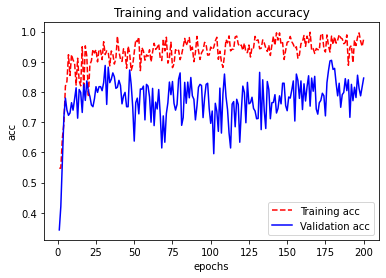

<Figure size 432x288 with 0 Axes>

In [17]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

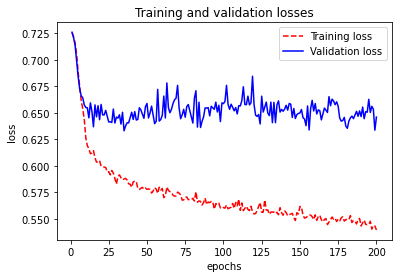

<Figure size 432x288 with 0 Axes>

In [18]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [19]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv(dataframes_path + "Pesos ResnetDA/AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv(dataframes_path +"Pesos ResnetDA/LossesDataFrame.csv", index=False)

In [20]:
accuracy_dataframe.sort_values(by=['val_auc'], ascending=False)

,train_auc,val_auc
178,0.985222,0.905123
177,0.932353,0.903226
30,0.924138,0.888046
32,0.932933,0.882353
180,0.983135,0.878558
...,...,...
67,0.904297,0.614801
101,0.948039,0.595825
2,0.647116,0.569260
1,0.547783,0.421252


In [136]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load(dataframes_path + 'Pesos ResnetDA/resnet_weights_160.pt')
# checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_195.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = ("cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [137]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv(dataframes_path + "Pesos ResnetDA/Submission.csv", index=False)

In [138]:
df_test = pd.read_csv(dataframes_path + "test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[227  51]
 [ 71 192]]
------------Exactitud-------------------
0.7744916820702403
------------Precision-------------------
0.7755407944675479
[0.76174497 0.79012346]
------------Sensibilidad-------------------
0.7744916820702403
[0.81654676 0.73003802]
------------F1 score-------------------
0.7739500709092045
[0.78819444 0.75889328]
